# 导入库

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchvision.datasets import ImageFolder

# 读取数据

In [3]:
# 读取数据
# 训练集目录
TRAIN_DIRS = ['./dataset_torch/train1', './dataset_torch/train2', './dataset_torch/train3', './dataset_torch/train4', './dataset_torch/train5']
# 验证集目录
VAL_DIRS = ['./dataset_torch/val1', './dataset_torch/val2', './dataset_torch/val3', './dataset_torch/val4', './dataset_torch/val5']

# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 数据处理

In [3]:
# 定义归一化转换，将像素值归一化到 [-1, 1] 之间
normalize = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    normalize  # 应用归一化
])

val_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    normalize  # 应用归一化
])

# CUDA加速

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

# CNN神经网络

In [6]:
class Cnn(nn.Module):
    def __init__(self, input_shape):
        super(Cnn, self).__init__()
        self.input_shape = input_shape

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, padding=0, stride = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(18496, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze(1)

input_shape = (3, 150, 150)
model = Cnn(input_shape).to(device)
print(model)
from torchsummary import summary
#summary(model, input_size=input_shape)

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=18496, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


# 损失函数和优化器

In [6]:
# 定义一个损失函数
loss_fn = nn.BCELoss()
# 定义一个优化器
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# 学习率每隔10轮变为原来的0.5
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 训练函数

In [7]:
# 定义训练函数
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    loss, current, n = 0.0, 0.0, 0
    for batch, (x, y) in enumerate(dataloader):
        image, y = x.to(device), y.to(device).float()  # Ensure y is float
        output = model(image)
        cur_loss = loss_fn(output, y)
        cur_acc = torch.sum((y == output.round()).int()).float() / output.shape[0]

        # 反向传播
        optimizer.zero_grad()
        cur_loss.backward()
        optimizer.step()
        loss += cur_loss.item()
        current += cur_acc.item()
        n = n+1

    train_loss = loss / n
    train_acc = current / n
    print('train_loss: {:.4f}     train_acc: {:.4f}'.format(train_loss, train_acc))
    return train_loss, train_acc

# 验证函数

In [8]:
def val(dataloader, model, loss_fn):
    # 将模型转化为验证模型
    model.eval()
    loss, current, n = 0.0, 0.0, 0
    with torch.no_grad():
        for batch, (x, y) in enumerate(dataloader):
            image, y = x.to(device), y.to(device).float()  # Ensure y is float
            output = model(image)
            cur_loss = loss_fn(output, y)
            cur_acc = torch.sum((y == output.round()).int()).float() / output.shape[0]
            loss += cur_loss.item()
            current += cur_acc.item()
            n = n + 1

    val_loss = loss / n
    val_acc = current / n
    print('val_loss: {:.4f}     val_acc: {:.4f}'.format(val_loss, val_acc))
    print()
    return val_loss, val_acc

In [9]:
# 定义画图函数
def matplot_loss(train_loss, val_loss):
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.legend(loc='best')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title("训练集和验证集loss值对比图")
    plt.show()

def matplot_acc(train_acc, val_acc):
    plt.plot(train_acc, label='train_acc')
    plt.plot(val_acc, label='val_acc')
    plt.legend(loc='best')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.title("训练集和验证集acc值对比图")
    plt.show()

# 开始训练

epoch1
-----------
train_loss: 0.6924     train_acc: 0.5106
val_loss: 0.6869     val_acc: 0.5125

epoch2
-----------
train_loss: 0.6771     train_acc: 0.5644
val_loss: 0.6715     val_acc: 0.5925

epoch3
-----------
train_loss: 0.6380     train_acc: 0.6431
val_loss: 0.6371     val_acc: 0.6375

epoch4
-----------
train_loss: 0.6199     train_acc: 0.6525
val_loss: 0.6189     val_acc: 0.6550

epoch5
-----------
train_loss: 0.5779     train_acc: 0.7069
val_loss: 0.5927     val_acc: 0.6750

epoch6
-----------
train_loss: 0.5523     train_acc: 0.7200
val_loss: 0.5791     val_acc: 0.6975

epoch7
-----------
train_loss: 0.5548     train_acc: 0.7206
val_loss: 0.5955     val_acc: 0.7025

epoch8
-----------
train_loss: 0.5231     train_acc: 0.7494
val_loss: 0.5668     val_acc: 0.6950

epoch9
-----------
train_loss: 0.5082     train_acc: 0.7625
val_loss: 0.5875     val_acc: 0.6950

epoch10
-----------
train_loss: 0.4777     train_acc: 0.7769
val_loss: 0.5640     val_acc: 0.7300

epoch11
-----------

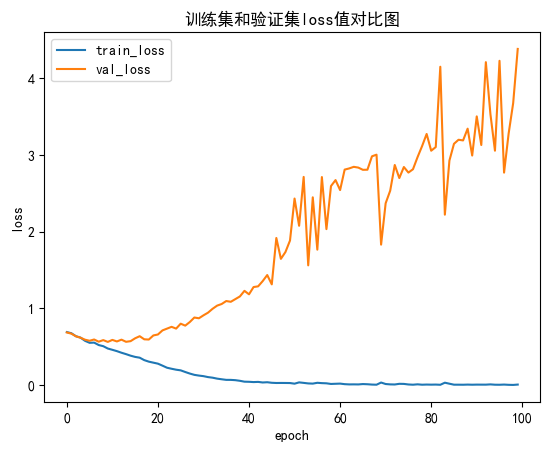

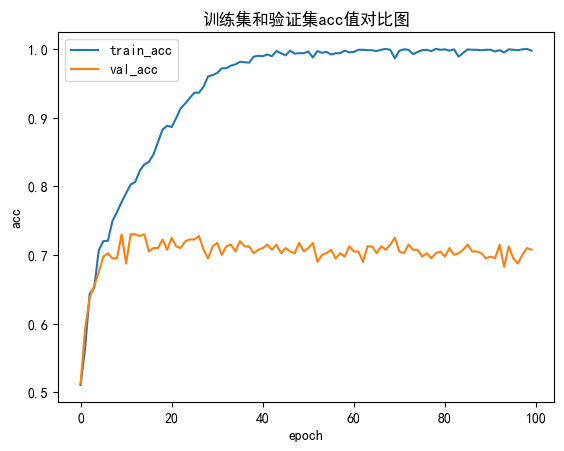

Done!


In [10]:
# 开始训练
min_acc = 0

#model = Cnn().to(device)

#optimizer = torch.optim.RMSprop(model.parameters())
#for i in range (5):
for i in range (1):
    ROOT_TRAIN = TRAIN_DIRS[i]
    ROOT_TEST = VAL_DIRS[i]
    train_dataset = ImageFolder(ROOT_TRAIN, transform=train_transform)
    val_dataset = ImageFolder(ROOT_TEST, transform=val_transform)

    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
    loss_train = []
    acc_train = []
    loss_val = []
    acc_val = []

    epoch = 100
    for t in range(epoch):
        #lr_scheduler.step()
        print(f"epoch{t+1}\n-----------")
        train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
        val_loss, val_acc = val(val_dataloader, model, loss_fn)

        loss_train.append(train_loss)
        acc_train.append(train_acc)
        loss_val.append(val_loss)
        acc_val.append(val_acc)
    matplot_loss(loss_train, loss_val)
    matplot_acc(acc_train, acc_val)
print('Done!')

In [35]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time

In [36]:
class Cnn(nn.Module):
    def __init__(self, input_shape):
        super(Cnn, self).__init__()
        self.input_shape = input_shape

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, padding=0, stride = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(18496, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x.squeeze(1)

input_shape = (3, 150, 150)
from torchsummary import summary
#summary(model, input_size=input_shape)

In [38]:
model = torch.load('cnn-torch-100.pth').to('cpu')
model.eval()
# 设置随机种子以确保结果的可重复性（可选）
torch.manual_seed(0)
# 生成250个这样的张量
tensor_list = [torch.randn(1, 3, 150, 150) for _ in range(250)]
all_time = []
for i in range (250):
    input = tensor_list[i].to('cpu')
    start = time.perf_counter()
    output = model(input)
    end = time.perf_counter()
    all_time.append(end-start)
#print(all_time)
all = 0
for i in range (50,250):
    all  += all_time[i]
print(all/200)

0.003920423999961713
